In [1]:
from pandas_datareader import data, wb
from scipy.stats import genpareto,burr,expon # 0.18.1
from scipy.stats.mstats import mquantiles
import matplotlib.pyplot as plt # mpl version 2.0.0
import pandas as pd # version 0.19.2
import numpy as np # version 1.11.3
import seaborn as sns # version 0.7.1
import datetime as dt

FIG_SIZE = (11,10)  # global mpl figure size
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (11, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

%matplotlib inline

In [2]:
# Download SPY ETF price data and compute daily simple returns
start_date = dt.datetime(2011,1,4) 
end_date = dt.datetime(2017,5,1)
price_df = data.DataReader('SPY','google',start=start_date,end=end_date)['Close']
rtndf = pd.DataFrame(price_df.pct_change().dropna())

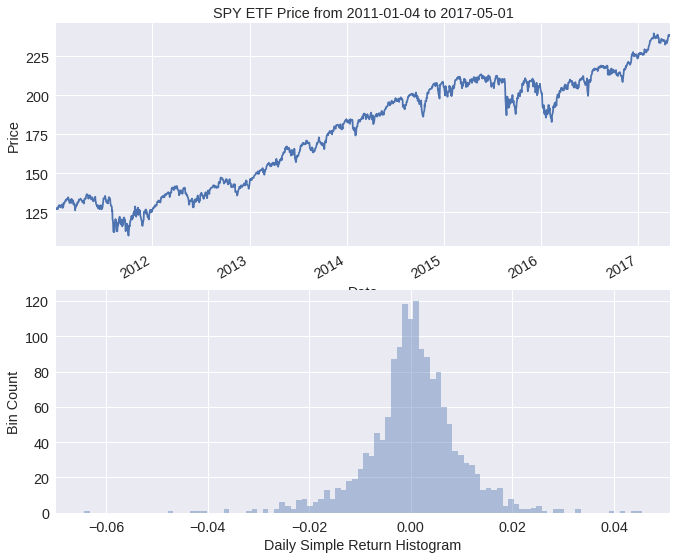

In [3]:
# Plot ETF price and daily return histogram
plt.figure(figsize=FIG_SIZE)
plt.subplot(2,1,1)
price_df.plot(title="SPY ETF Price from " + str(start_date.date()) + " to " + str(end_date.date()));
plt.ylabel('Price')
plt.subplot(2,1,2)
sns.distplot(rtndf,bins=100,kde=False,axlabel='Daily Simple Return Histogram');
plt.ylabel('Bin Count')

In [4]:
# Only consider the loss (negative returns) part of the distribution 
# and perform an MLE fit to an exponential distribution.
left_tail = -rtndf[rtndf<0].dropna()
(loc_fit,scale_fit)=expon.fit(left_tail)

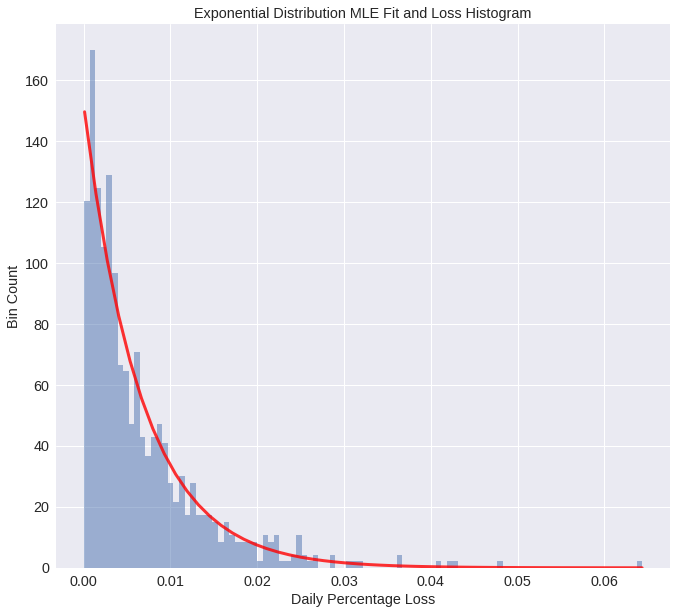

In [5]:
# Plot MLE fit on top of loss distribution histogram
eps = 1e-4
x = np.linspace(eps,float(np.max(left_tail)))

fig, ax = plt.subplots(1, 1,figsize=FIG_SIZE);
ax.plot(x, expon.pdf(x, loc_fit,scale_fit),
       'r-', lw=3, alpha=0.8, label='MLE Exponential PDF Fit');
ax.hist(left_tail['Close'], normed=True, histtype='stepfilled', alpha=0.5,bins=100);
plt.title('Exponential Distribution MLE Fit and Loss Histogram');
plt.xlabel('Daily Percentage Loss')
plt.ylabel('Bin Count')


In [6]:
    # Quantile Estimation Monte Carlo Simulation.  We fix a number of i.i.d. draws from the 
    # best fit MLE exponential distribution and estimate the 0.9, 0.98, and 0.998 quantiles.
    # This simulation is repeated 100,000 times, and the standard deviation of the quantile 
    # estimators is computed.
    
    num_sims = 100000
    sim_size = (61,126,252,252*5,252*10,252*100)
    res_lst = []

    for sz in sim_size:
        qtilelst=[]
        for i in xrange(1,num_sims):
            samp=expon.rvs(loc=loc_fit, scale=scale_fit, size=sz)
            qtilelst.append(mquantiles(samp,prob=[0.9,0.98,0.998],alphap=1/3,betap=1/3))
        
        mean_qtile = np.mean(np.array(qtilelst),axis=0)
        std_qtile = np.std(np.array(qtilelst),axis=0)
        res_lst.append([sz]+list(mean_qtile)+list(std_qtile))

In [7]:
# We display results of the Monte Carlo simulation.
pd.DataFrame(res_lst,columns=['Samp Size','0.9 Mean','0.98 Mean','0.998 Mean','0.9 Std','0.98 Std','0.998 Std'])

,Samp Size,0.9 Mean,0.98 Mean,0.998 Mean,0.9 Std,0.98 Std,0.998 Std
0,61,0.015819,0.029588,0.031179,0.002616,0.007266,0.008431
1,126,0.015547,0.027510,0.035940,0.001787,0.004400,0.008470
2,252,0.015423,0.026639,0.040566,0.001258,0.003059,0.008504
3,1260,0.015327,0.026097,0.042813,0.000561,0.001312,0.004443
4,2520,0.015315,0.026035,0.041910,0.000397,0.000928,0.003096
5,25200,0.015304,0.025973,0.041288,0.000125,0.000292,0.000933


In [8]:
# Here we define the standard deviation of the order statistic distribution mentioned in the article
def f(x,x0,lam):
    return 1/lam*np.exp(-(x-x0)/lam)
def Finv(q,x0,lam):
    return x0 - lam*np.log(1-q)
def ord_stat_std(q,n,x0,lam):
    return np.sqrt(q*(1-q)/(n*f(Finv(q,x0,lam),x0,lam)**2))

In [9]:
# These are the actual quantiles computed from the quantile function we are estimating.
Finv(np.array([0.9,0.98,0.998]),loc_fit,scale_fit)

array([ 0.01530295,  0.02596728,  0.04122448])

In [10]:
# We compute the asymptotic order statistic standard deviation for each simulation case to compare 
est_var=[ord_stat_std(np.array([0.9,0.98,0.998]),sz,loc_fit,scale_fit) for sz in sim_size]
true_std = pd.DataFrame(est_var,columns=["0.9 Std","0.98 Std","0.998 Std"])
true_std['Samp Size'] = sim_size
true_std

,0.9 Std,0.98 Std,0.998 Std,Samp Size
0,0.002545,0.005939,0.018952,61
1,0.001771,0.004132,0.013186,126
2,0.001252,0.002922,0.009324,252
3,0.000560,0.001307,0.004170,1260
4,0.000396,0.000924,0.002949,2520
5,0.000125,0.000292,0.000932,25200


In [11]:
def point_rule_thumb(q,alpha,x0,lam):
    return q*(1-q)/(alpha*f(Finv(q,x0,lam),x0,lam))**2

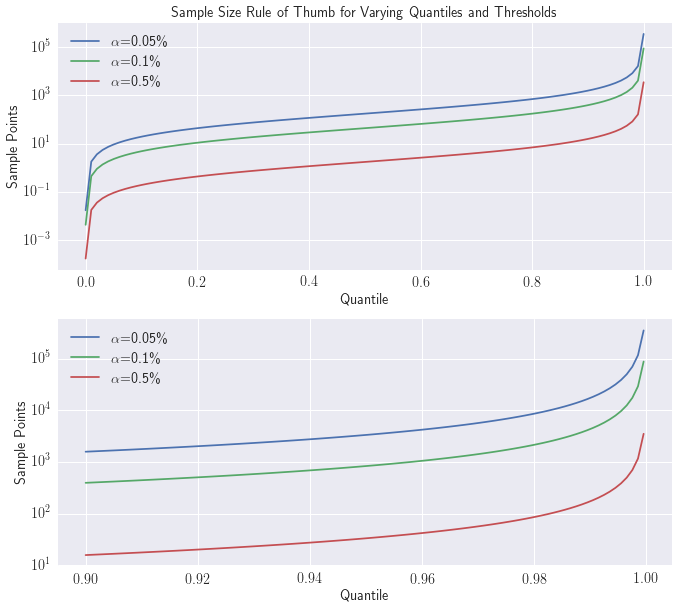

In [12]:
qgrid = np.linspace(eps,1-5*eps,100)
qgrid2 = np.linspace(0.9,1-5*eps,100)
vals1 = point_rule_thumb(qgrid,0.0005,loc_fit,scale_fit)
vals2 = point_rule_thumb(qgrid,0.001,loc_fit,scale_fit)
vals3 = point_rule_thumb(qgrid,0.005,loc_fit,scale_fit)
vals12 = point_rule_thumb(qgrid2,0.0005,loc_fit,scale_fit)
vals22 = point_rule_thumb(qgrid2,0.001,loc_fit,scale_fit)
vals32 = point_rule_thumb(qgrid2,0.005,loc_fit,scale_fit)

plt.figure(figsize=(10,5))
plt.rc('text', usetex=True)
plt.figure(figsize=FIG_SIZE)
plt.subplot(2,1,1)
plt.plot(qgrid,vals1,label=r'$\alpha$=0.05\%')
plt.plot(qgrid,vals2,label=r'$\alpha$=0.1\%')
plt.plot(qgrid,vals3,label=r'$\alpha$=0.5\%')
plt.yscale('log')
plt.legend(loc='upper left')
plt.xlabel('Quantile')
plt.ylabel('Sample Points')
plt.title("Sample Size Rule of Thumb for Varying Quantiles and Thresholds")
plt.subplot(2,1,2)
plt.plot(qgrid2,vals12,label=r'$\alpha$=0.05\%')
plt.plot(qgrid2,vals22,label=r'$\alpha$=0.1\%')
plt.plot(qgrid2,vals32,label=r'$\alpha$=0.5\%')
plt.yscale('log')
plt.legend(loc='upper left')
plt.xlabel('Quantile')
plt.ylabel('Sample Points')